In [1]:
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import mean_squared_error as MSE,mean_absolute_error
from tabulate import tabulate
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# 加载数据 

In [2]:
#Loading in the movies dataset
movies_df = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python')
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


我们可以对评级.dat文件执行相同的操作：

In [3]:
# Loading the ratings dataset
ratings_df = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


因此，我们的movies_df变量包含一个数据帧，用于存储电影的唯一 ID 号、标题和流派，而我们的ratings_df变量存储唯一的用户 ID 号、用户观看过的电影 ID、用户对所述电影的评分以及用户对该电影的评分。

现在，让我们重命名这些数据框中的列，以便更好地更直观地传达其数据：

In [4]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


And our final ratings_df:

In [5]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


# 受限玻尔兹曼机模型

## 设置数据格式

首先，让我们看看我们有多少部电影，看看电影 ID 是否与该值相对应：

In [6]:
len(movies_df)

3883

现在，我们可以开始将数据格式化为RBM的输入。我们将规范化用户评级存储为称为 trX 的用户评级矩阵，并对值进行规范化。

In [7]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
len

<function len(obj, /)>

In [9]:
user_rating_df[user_rating_df.index==215]

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
215,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets normalize it now:

In [10]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
trX[215]
#ratings_df[( ratings_df['UserID']==21)].sort_values(by=['MovieID'],ascending=True)

array([0., 0., 1., ..., 0., 0., 0.])

# 建立模型 RBM

In [12]:
errors_DBN_3=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 10 # Amount of training iterations
        self.learning_rate = 0.1  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBN_3.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)
      
    
    

## 建立DBM

In [13]:
RBM_hidden_sizes = [1500, 700 , 50 ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trX

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   3706 -> 1500
RBM:  1   1500 -> 700
RBM:  2   700 -> 50


## 训练

In [14]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)


New RBM:
Instructions for updating:
Use `tf.cast` instead.
Epoch: 0 reconstruction error: 0.062236
Epoch: 1 reconstruction error: 0.054669
Epoch: 2 reconstruction error: 0.050806
Epoch: 3 reconstruction error: 0.048128
Epoch: 4 reconstruction error: 0.045501
Epoch: 5 reconstruction error: 0.044023
Epoch: 6 reconstruction error: 0.042948
Epoch: 7 reconstruction error: 0.041855
Epoch: 8 reconstruction error: 0.041476
Epoch: 9 reconstruction error: 0.040370
New RBM:
Epoch: 0 reconstruction error: 0.222268
Epoch: 1 reconstruction error: 0.209946
Epoch: 2 reconstruction error: 0.203669
Epoch: 3 reconstruction error: 0.200190
Epoch: 4 reconstruction error: 0.198101
Epoch: 5 reconstruction error: 0.196654
Epoch: 6 reconstruction error: 0.195548
Epoch: 7 reconstruction error: 0.194792
Epoch: 8 reconstruction error: 0.194204
Epoch: 9 reconstruction error: 0.193632
New RBM:
Epoch: 0 reconstruction error: 0.149470
Epoch: 1 reconstruction error: 0.136514
Epoch: 2 reconstruction error: 0.123600
Epo

In [15]:
errors_DBN=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 0.1  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBN.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [16]:
RBM_hidden_sizes = [1500, 700 ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trX

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   3706 -> 1500
RBM:  1   1500 -> 700


In [17]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)

New RBM:
Epoch: 0 reconstruction error: 0.062011
Epoch: 1 reconstruction error: 0.054311
Epoch: 2 reconstruction error: 0.050733
Epoch: 3 reconstruction error: 0.048279
Epoch: 4 reconstruction error: 0.045275
Epoch: 5 reconstruction error: 0.044024
Epoch: 6 reconstruction error: 0.042953
Epoch: 7 reconstruction error: 0.041729
Epoch: 8 reconstruction error: 0.041358
Epoch: 9 reconstruction error: 0.040603
Epoch: 10 reconstruction error: 0.039324
Epoch: 11 reconstruction error: 0.038957
Epoch: 12 reconstruction error: 0.038847
Epoch: 13 reconstruction error: 0.038359
Epoch: 14 reconstruction error: 0.038438
New RBM:
Epoch: 0 reconstruction error: 0.000315
Epoch: 1 reconstruction error: 0.000407
Epoch: 2 reconstruction error: 0.000450
Epoch: 3 reconstruction error: 0.000517
Epoch: 4 reconstruction error: 0.000558
Epoch: 5 reconstruction error: 0.000572
Epoch: 6 reconstruction error: 0.000609
Epoch: 7 reconstruction error: 0.000637
Epoch: 8 reconstruction error: 0.000643
Epoch: 9 reconstr

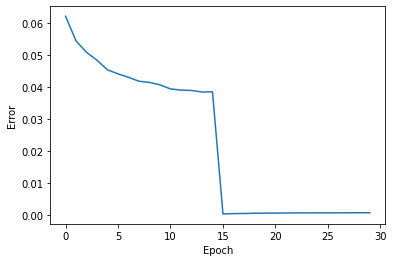

In [18]:
plt.plot(errors_DBN)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

# 建议

现在，我们可以预测任意选择的用户可能喜欢的电影。这可以通过将用户观看的电影首选项输入到RBM中，然后重建输入来实现。RBM 提供的值将尝试根据 RBM 受训的用户的首选项来估计用户对他没有看过的电影的偏好。

让我们首先选择模拟用户的用户 ID：

In [19]:
mock_user_id = 215

In [20]:
#Selecting the input user
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0.8, 0. , 0. , ..., 0. , 0. , 0. ]])

In [21]:
hiddenNodes = 20
visibleNodes =  len(user_rating_df.columns)
#Number of unique movies
visibleBias = tf.placeholder("float", [visibleNodes])
#Number of features we're going to learn
hiddenBias = tf.placeholder("float", [hiddenNodes])
# Weight Matrix
W = tf.placeholder("float", [visibleNodes, hiddenNodes])


#Phase 1: Input Processing
visible_0 = tf.placeholder("float", [None, visibleNodes])
_hidden_0 = tf.nn.sigmoid(tf.matmul(visible_0, W) + hiddenBias)
hidden_0 = tf.nn.relu(tf.sign(_hidden_0 - tf.random_uniform(tf.shape(_hidden_0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(hidden_0, tf.transpose(W)) + visibleBias) 
visible_1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
hidden_1 = tf.nn.sigmoid(tf.matmul(visible_1, W) + hiddenBias)

#Learning rate
alpha = 0.1
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(visible_0), hidden_0)
w_neg_grad = tf.matmul(tf.transpose(visible_1), hidden_1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(visible_0)[0])
#Create methods to update the weights and biases
update_weight = W + alpha * CD
update_vb = visibleBias + alpha * tf.reduce_mean(visible_0 - visible_1, 0)
update_hb = hiddenBias + alpha * tf.reduce_mean(hidden_0 - hidden_1, 0)

#Feeding in the user and reconstructing the input


sess = tf.Session()

#Current weight
current_weight = np.zeros([visibleNodes, hiddenNodes], np.float32)
#Current visible unit biases
current_vb = np.zeros([visibleNodes], np.float32)
#Current hidden unit biases
current_hb = np.zeros([hiddenNodes], np.float32)
#Previous weight
previous_weight = np.zeros([visibleNodes, hiddenNodes], np.float32)
#Previous visible unit biases
previous_vb = np.zeros([visibleNodes], np.float32)
#Previous hidden unit biases
previous_hb = np.zeros([hiddenNodes], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())


err = visible_0 - visible_1
err_sum = tf.reduce_mean(err * err)

epochs = 30
batchsize = 200
errors_RBM = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        current_weight = sess.run(update_weight, feed_dict={visible_0: batch, W: previous_weight, visibleBias: previous_vb, hiddenBias: previous_hb})
        current_vb = sess.run(update_vb, feed_dict={visible_0: batch, W: previous_weight, visibleBias: previous_vb, hiddenBias: previous_hb})
        cur_nb = sess.run(update_hb, feed_dict={visible_0: batch, W: previous_weight, visibleBias: previous_vb, hiddenBias: previous_hb})
        previous_weight = current_weight
        previous_vb = current_vb
        previous_hb = current_hb
    errors_RBM.append(sess.run(err_sum, feed_dict={visible_0: trX, W: current_weight, visibleBias: current_vb, hiddenBias: current_hb}))

# hidden_0 = RBM.prob_h_given_v()
# vv1 = RBM.prob_v_given_h
hidden_0 = tf.nn.sigmoid(tf.matmul(visible_0, W) + hiddenBias)
vv1 = tf.nn.sigmoid(tf.matmul(hidden_0, tf.transpose(W)) + visibleBias)

feed = sess.run(hidden_0, feed_dict={ visible_0: inputUser, W: previous_weight, hiddenBias: previous_hb})
rec = sess.run(vv1, feed_dict={ hidden_0: feed, W: previous_weight, visibleBias: previous_vb})
print(rec)

[[0.32400635 0.10962796 0.03380817 ... 0.0029256  0.00200315 0.02057845]]


In [22]:
errors_DBN_sigmoid=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 0.1  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBN_sigmoid.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [23]:
RBM_hidden_sizes = [1500, 700  ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trX

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   3706 -> 1500
RBM:  1   1500 -> 700


In [24]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)


New RBM:
Epoch: 0 reconstruction error: 0.061268
Epoch: 1 reconstruction error: 0.054601
Epoch: 2 reconstruction error: 0.050770
Epoch: 3 reconstruction error: 0.047937
Epoch: 4 reconstruction error: 0.045839
Epoch: 5 reconstruction error: 0.044295
Epoch: 6 reconstruction error: 0.042725
Epoch: 7 reconstruction error: 0.042374
Epoch: 8 reconstruction error: 0.041109
Epoch: 9 reconstruction error: 0.040345
Epoch: 10 reconstruction error: 0.040073
Epoch: 11 reconstruction error: 0.040000
Epoch: 12 reconstruction error: 0.038910
Epoch: 13 reconstruction error: 0.038144
Epoch: 14 reconstruction error: 0.038151
New RBM:
Epoch: 0 reconstruction error: 0.225954
Epoch: 1 reconstruction error: 0.213956
Epoch: 2 reconstruction error: 0.208026
Epoch: 3 reconstruction error: 0.203837
Epoch: 4 reconstruction error: 0.201907
Epoch: 5 reconstruction error: 0.198930
Epoch: 6 reconstruction error: 0.197424
Epoch: 7 reconstruction error: 0.196396
Epoch: 8 reconstruction error: 0.196199
Epoch: 9 reconstr

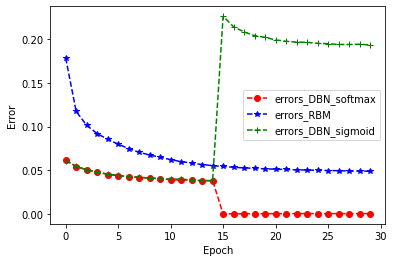

In [25]:
# plt.plot(errors_DBN,'--or',errors_RBM,'--*b',errors_DBN_sigmoid,'--g+',
#          label='errors_DBN_sigmoid,errors_RBM,errors_DBN_sigmoid')
plt.plot(errors_DBN,'--or',label='errors_DBN_softmax')
plt.plot(errors_RBM,'--*b',label='errors_RBM')
plt.plot(errors_DBN_sigmoid,'--g+',label='errors_DBN_sigmoid')
plt.legend()

plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

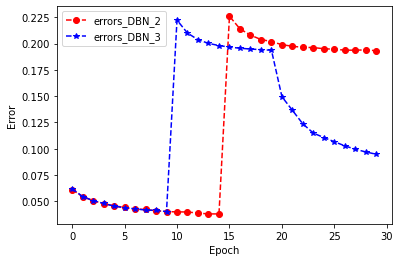

In [26]:
plt.plot(errors_DBN_sigmoid,'--or',label='errors_DBN_2')
plt.plot(errors_DBN_3,'--*b',label='errors_DBN_3')
plt.legend()

plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [27]:
name=['UserID','MovieID','Rating','Timestamp']
ratings_dfs=pd.read_csv('ml-100k/u.data',sep='\t',names=name)
ratings_dfs.head()

,UserID,MovieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [28]:
user_rating_dfs = ratings_dfs.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_dfs.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
user_rating_dfs[user_rating_dfs.index==215]

MovieID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
UserID,,,,,,,,,,,,,,,,,,,,,
215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
norm_user_rating_dfs = user_rating_dfs.fillna(0) / 5.0
trXs = norm_user_rating_dfs.values
trXs[0:5]

array([[1. , 0.6, 0.8, ..., 0. , 0. , 0. ],
       [0.8, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.8, 0.6, 0. , ..., 0. , 0. , 0. ]])

In [31]:
trXs[215]
#ratings_df[( ratings_df['UserID']==21)].sort_values(by=['MovieID'],ascending=True)

array([0.8, 0. , 0.8, ..., 0. , 0. , 0. ])

In [32]:
errors_DBNs=[]
class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 0.175  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBNs.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [33]:
RBM_hidden_sizes = [800, 400  ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trXs

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   1682 -> 800
RBM:  1   800 -> 400


In [34]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)


New RBM:
Epoch: 0 reconstruction error: 0.115966
Epoch: 1 reconstruction error: 0.102762
Epoch: 2 reconstruction error: 0.093868
Epoch: 3 reconstruction error: 0.085535
Epoch: 4 reconstruction error: 0.077539
Epoch: 5 reconstruction error: 0.072503
Epoch: 6 reconstruction error: 0.068892
Epoch: 7 reconstruction error: 0.067111
Epoch: 8 reconstruction error: 0.066014
Epoch: 9 reconstruction error: 0.064451
Epoch: 10 reconstruction error: 0.063491
Epoch: 11 reconstruction error: 0.062904
Epoch: 12 reconstruction error: 0.061385
Epoch: 13 reconstruction error: 0.060479
Epoch: 14 reconstruction error: 0.059784
New RBM:
Epoch: 0 reconstruction error: 0.000236
Epoch: 1 reconstruction error: 0.000272
Epoch: 2 reconstruction error: 0.000319
Epoch: 3 reconstruction error: 0.000324
Epoch: 4 reconstruction error: 0.000373
Epoch: 5 reconstruction error: 0.000429
Epoch: 6 reconstruction error: 0.000446
Epoch: 7 reconstruction error: 0.000526
Epoch: 8 reconstruction error: 0.000574
Epoch: 9 reconstr

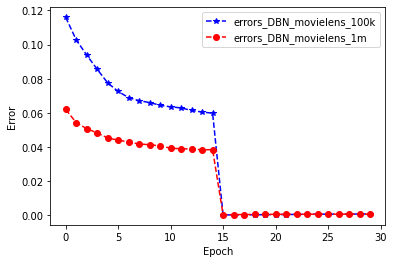

In [35]:
plt.plot(errors_DBNs,'--*b',label='errors_DBN_movielens_100k')
plt.plot(errors_DBN,'--or',label='errors_DBN_movielens_1m')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [1]:
plt.plot(errors_DBNs,'--*b',label='errors_DBN_movielens_100k')
plt.plot(errors_DBN,'--or',label='errors_DBN_movielens_1m')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Epoch')
# plt.xlim(15,30)
# plt.yticks(range(10))
# set(gca,'XLim',[15 45])
plt.show()

NameError: name 'plt' is not defined